训练一个图像分类器
----------------------------

依次按照下列顺序进行：

1. 数据：建立训练+测试数据集。使用``torchvision``加载和归一化CIFAR10训练集和测试集
2. 建模：定义一个卷积神经网络
3. 损失：定义损失函数
4. 训练：在训练集上训练网络
5. 测试：在测试集上测试网络

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 0.硬件环境确认

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 确认我们的电脑支持CUDA，然后显示CUDA信息：
print(device)

cuda:0


## 1.数据：建立训练+测试数据集
----------------------------------------

使用``torchvision``可以非常容易地加载CIFAR10。    
torchvision的输出是[0,1]的PILImage图像，我们把它转换为归一化范围为[-1, 1]的张量。

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们展示一些训练图像。

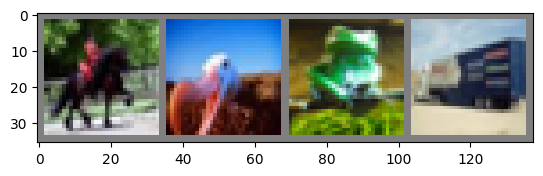

horse  bird  frog truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取随机数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2.建模：定义一个卷积神经网络

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 卷积1->relu激活->池化
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积2->relu激活->池化
        x = self.pool(F.relu(self.conv2(x)))
        # 变形为1维
        x = x.view(-1, 16 * 5 * 5)
        # x = torch.flatten(x, 1)
        # 全联接1（16*5*5->120）->relu激活
        x = F.relu(self.fc1(x))
        # 全联接2（120->84）->relu激活
        x = F.relu(self.fc2(x))
        # 全联接3（84->10）
        x = self.fc3(x)
        # 返回计算结果
        return x

net = Net()
# cuda
# net.to(device)

In [6]:
# x = torch.ones(1, 16, 5, 5)
# print(x.shape)
# x = x.view(-1, 16 * 5 * 5)
# print(x.shape)

# x = torch.ones(1, 16, 5, 5)
# print(x.shape)
# x = torch.flatten(x, 1)
# print(x.shape)

conv1 = nn.Conv2d(3, 6, 5)
input = torch.ones(3, 32, 32)

In [7]:
# 测试模型输入输出
# x = torch.ones(3, 32, 32)
# x = x.to(device) # cuda
# # print(x)

# with torch.no_grad():
#     outputs = net(x)
#     print(outputs)

## 3.损失：定义损失函数
----------------------------------------

我们使用交叉熵作为损失函数，使用带动量的随机梯度下降。

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4.训练：在训练集上训练网络
--------------------------------
有趣的时刻开始了。
我们只需在数据迭代器上循环，将数据输入给网络，并优化。

In [9]:
for epoch in range(2):  # 多批次循环

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 使用cuda设备
        # inputs, labels = inputs.to(device), labels.to(device)

        # 梯度置0
        optimizer.zero_grad()

        # 正向传播，反向传播，优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印状态信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000批次打印一次
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.835
[1,  6000] loss: 1.668
[1,  8000] loss: 1.580
[1, 10000] loss: 1.510
[1, 12000] loss: 1.461
[2,  2000] loss: 1.409
[2,  4000] loss: 1.361
[2,  6000] loss: 1.330
[2,  8000] loss: 1.310
[2, 10000] loss: 1.291
[2, 12000] loss: 1.291
[3,  2000] loss: 1.208
[3,  4000] loss: 1.183
[3,  6000] loss: 1.226
[3,  8000] loss: 1.173
[3, 10000] loss: 1.175
[3, 12000] loss: 1.154
[4,  2000] loss: 1.088
[4,  4000] loss: 1.108
[4,  6000] loss: 1.093
[4,  8000] loss: 1.104
[4, 10000] loss: 1.101
[4, 12000] loss: 1.093
[5,  2000] loss: 1.018
[5,  4000] loss: 1.028
[5,  6000] loss: 1.037
[5,  8000] loss: 1.050
[5, 10000] loss: 1.029
[5, 12000] loss: 1.017
[6,  2000] loss: 0.963
[6,  4000] loss: 0.972
[6,  6000] loss: 0.977
[6,  8000] loss: 0.991
[6, 10000] loss: 0.993
[6, 12000] loss: 0.980
[7,  2000] loss: 0.903
[7,  4000] loss: 0.921
[7,  6000] loss: 0.937
[7,  8000] loss: 0.943
[7, 10000] loss: 0.942
[7, 12000] loss: 0.970
[8,  2000] loss: 0.847
[8,  4000] 

保存我们训练的模型

In [10]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

## 5.测试：在测试集上测试网络
-------------------------------------

第一步，显示测试集中的图片并熟悉图片内容。

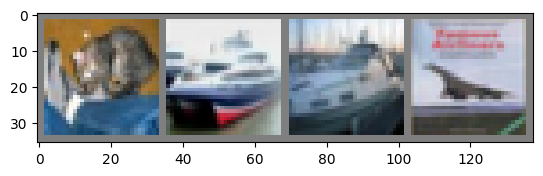

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

加载之前保存的模型

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

预测：让我们看看神经网络认为以上图片是什么。

In [13]:
outputs = net(images)

输出是10个标签的能量。
一个类别的能量数值越大，神经网络越认为它是这个类别。所以让我们得到最高能量的标签。

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship plane plane


结果看来不错。

接下来让看看网络在整个测试集上的结果如何。

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
# 因为我们没有在训练，所以我们不需要计算output输出的梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        # 通过网络模型计算images的输出
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        # 我们选择能量最高的分类作为预测结果
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


统计每个分类的预测效果数值百分比

In [16]:
# prepare to count predictions for each class
# 准备为每一个分类的预测结果进行计数
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
# 同上，这里进行预测，不需要计算梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) # 网络模型预测images得到输出outputs
        _, predictions = torch.max(outputs, 1) # 使用最高能量的分类作为预测结果

        # collect the correct predictions for each class
        # 收集每个分类的正确预测结果
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
# 打印每个分类的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 74.3 %
Accuracy for class: car   is 58.7 %
Accuracy for class: bird  is 49.1 %
Accuracy for class: cat   is 41.7 %
Accuracy for class: deer  is 48.1 %
Accuracy for class: dog   is 54.0 %
Accuracy for class: frog  is 67.3 %
Accuracy for class: horse is 61.1 %
Accuracy for class: ship  is 64.2 %
Accuracy for class: truck is 76.4 %
